# Early Stopping with MLJ

This demonstration is available as a Jupyter notebook or julia script
[here](https://github.com/FluxML/MLJFlux.jl/tree/dev/docs/src/common_workflows/early_stopping).

In this workflow example, we learn how MLJFlux enables us to easily use early stopping
when training MLJFlux models.

In [1]:
using Pkg
PKG_ENV = joinpath(@__DIR__, "..", "..", "..")
Pkg.activate(PKG_ENV);
Pkg.instantiate();

  Activating project at `~/GoogleDrive/Julia/MLJ/MLJFlux/docs`


**This script tested using Julia 1.10**

### Basic Imports

In [2]:
using MLJ               # Has MLJFlux models
using Flux              # For more flexibility
using Plots             # To visualize training
import Optimisers       # native Flux.jl optimisers no longer supported
using StableRNGs        # for reproducibility across Julia versions

stable_rng() = StableRNGs.StableRNG(123)

stable_rng (generic function with 1 method)

### Loading and Splitting the Data

In [3]:
iris = load_iris() # a named-tuple of vectors
y, X = unpack(iris, ==(:target), rng=stable_rng())
X = fmap(column-> Float32.(column), X) # Flux prefers Float32 data

(sepal_length = Float32[6.1, 7.3, 6.3, 4.8, 5.9, 7.1, 6.7, 5.4, 6.0, 6.9  …  5.0, 6.4, 5.7, 4.6, 5.5, 4.6, 5.6, 5.7, 6.0, 5.0], sepal_width = Float32[2.9, 2.9, 3.4, 3.4, 3.0, 3.0, 3.0, 3.9, 3.0, 3.1  …  3.3, 2.7, 2.5, 3.2, 2.4, 3.1, 2.8, 3.0, 2.9, 3.5], petal_length = Float32[4.7, 6.3, 5.6, 1.9, 5.1, 5.9, 5.0, 1.7, 4.8, 4.9  …  1.4, 5.3, 5.0, 1.4, 3.7, 1.5, 4.9, 4.2, 4.5, 1.6], petal_width = Float32[1.4, 1.8, 2.4, 0.2, 1.8, 2.1, 1.7, 0.4, 1.8, 1.5  …  0.2, 1.9, 2.0, 0.2, 1.0, 0.2, 2.0, 1.2, 1.5, 0.6])

### Instantiating the model Now let's construct our model. This follows a similar setup
to the one followed in the [Quick Start](../../index.md#Quick-Start).

In [4]:
NeuralNetworkClassifier = @load NeuralNetworkClassifier pkg=MLJFlux

clf = NeuralNetworkClassifier(
    builder=MLJFlux.MLP(; hidden=(5,4), σ=Flux.relu),
    optimiser=Optimisers.Adam(0.01),
    batch_size=8,
    epochs=50,
    rng=stable_rng(),
)

[ Info: For silent loading, specify `verbosity=0`. 
import MLJFlux ✔


NeuralNetworkClassifier(
  builder = MLP(
        hidden = (5, 4), 
        σ = NNlib.relu), 
  finaliser = NNlib.softmax, 
  optimiser = Optimisers.Adam(eta=0.01, beta=(0.9, 0.999), epsilon=1.0e-8), 
  loss = Flux.Losses.crossentropy, 
  epochs = 50, 
  batch_size = 8, 
  lambda = 0.0, 
  alpha = 0.0, 
  rng = StableRNGs.LehmerRNG(state=0x000000000000000000000000000000f7), 
  optimiser_changes_trigger_retraining = false, 
  acceleration = ComputationalResources.CPU1{Nothing}(nothing), 
  embedding_dims = Dict{Symbol, Real}())

### Wrapping it in an IteratedModel

Let's start by defining the condition that can cause the model to early stop.

In [5]:
stop_conditions = [
    Step(1),            # Repeatedly train for one iteration
    NumberLimit(100),   # Don't train for more than 100 iterations
    Patience(5),        # Stop after 5 iterations of disimprovement in validation loss
    NumberSinceBest(9), # Or if the best loss occurred 9 iterations ago
    TimeLimit(30/60),   # Or if 30 minutes passed
]

5-element Vector{Any}:
 IterationControl.Step(1)
 EarlyStopping.NumberLimit(100)
 EarlyStopping.Patience(5)
 EarlyStopping.NumberSinceBest(9)
 EarlyStopping.TimeLimit(Dates.Millisecond(1800000))

We can also define callbacks. Here we want to store the validation loss for each iteration

In [6]:
validation_losses = []
callbacks = [
    WithLossDo(loss->push!(validation_losses, loss)),
]

1-element Vector{IterationControl.WithLossDo{Main.var"##226".var"#3#4"}}:
 IterationControl.WithLossDo{Main.var"##226".var"#3#4"}(Main.var"##226".var"#3#4"(), false, nothing)

Construct the iterated model and pass to it the stop_conditions and the callbacks:

In [7]:
iterated_model = IteratedModel(
    model=clf,
    resampling=Holdout(fraction_train=0.7); # loss and stopping are based on out-of-sample
    measures=log_loss,
    iteration_parameter=:(epochs),
    controls=vcat(stop_conditions, callbacks),
    retrain=false            # no need to retrain on all data at the end
);

You can see more advanced stopping conditions as well as how to involve callbacks in the
[documentation](https://juliaai.github.io/MLJ.jl/stable/controlling_iterative_models/#Controlling-Iterative-Models)

### Training with Early Stopping

At this point, all we need is to fit the model and iteration controls will be
automatically handled

In [8]:
mach = machine(iterated_model, X, y)
fit!(mach)
# We can get the training losses like so
training_losses = report(mach).model_report.training_losses;

[ Info: Training machine(ProbabilisticIteratedModel(model = NeuralNetworkClassifier(builder = MLP(hidden = (5, 4), …), …), …), …).
[ Info: final loss: 0.024808875413973978
[ Info: final training loss: 0.07397421
[ Info: Stop triggered by EarlyStopping.NumberLimit(100) stopping criterion. 
[ Info: Total of 100 iterations. 


### Results

We can see that the model converged after 100 iterations.

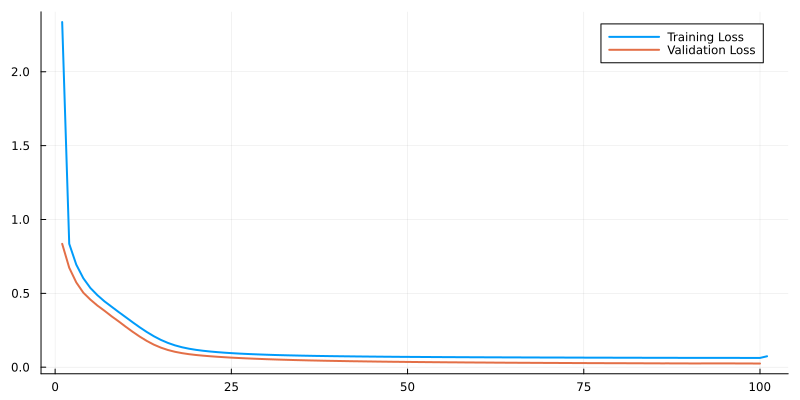

In [9]:
plot(training_losses, label="Training Loss", linewidth=2)
plot!(validation_losses, label="Validation Loss", linewidth=2, size=(800,400))

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*